## Introduction

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erf
from time import time,sleep
from scipy.stats import norm
from random import random

## Util functions

In [22]:
def plot_path(prices_path:np.ndarray,scale : float= 1.):
  """
    plot prices paths generated by the PathGenerator class
    can scale the output fig with the "scale" argument
  """
  plotabble = prices_path if len(prices_path.shape)==1 else prices_path if prices_path.shape[1] <100 else prices_path[:100]
  fig,ax = plt.subplots(figsize=(int(7*scale),int(5*scale)))
  ax.plot(plotabble)
  plt.show()

In [23]:
def time_it(func):
  def wrapped(*args,**kwargs):
    start_time = time()
    res = func(*args,**kwargs)
    end_time = time()
    print(f"Execution time is {end_time - start_time : .2f} seconds")
    return res
  return wrapped

## Path generator class

### Model and wrapper

In [94]:
def price_move_black_scholes(S:np.ndarray,v:np.ndarray,dt:float,r:float,sigma:float):
    """
    Compute S_(t+dt) base on the vector of prices St (S) and market paremters
    Returns the price vector S(t+dt)
    """
    dwt = np.random.normal(size=(S.shape)) * np.sqrt(dt)
    dSt = r*S * dt + S * sigma * dwt
    return S + dSt,v

In [83]:
def price_move_Heston(S:np.ndarray,v:np.ndarray,dt:float,r:float,kappa:float,theta:float,vol_of_vol:float,rho:float):
    """
    Compute S_(t+dt) base on the vector of prices St (S) and market paremters
    Returns the price vector S(t+dt)
    S is a price vector (dim 1)
    """
    means = np.array([0.,0.])
    cov = np.array([[1,rho],[rho,1]])

    correlated_normal_variable = np.random.multivariate_normal(means,cov,size=S.size)
    dwt = correlated_normal_variable[:,0] *  np.sqrt(dt)
    dbt = correlated_normal_variable[:,1] * np.sqrt(dt)

    dvt = kappa*(theta-v) * dt + vol_of_vol * np.sqrt(v) * dbt
    v = v + dvt

    dSt = r*S * dt + S * np.sqrt(v) * dwt

    return S + dSt,v

In [89]:
class PathGenerator:
  """
  Used to generate prices path with fixed market setting :
      r : interest rate
      sigma : volatility
      T : maturity/stop time
      S0 : starting price of the asset
  
  Computes the increments of the asset price using the "price_move_function" argument and its arguments "price_move_function_args"
      price_move_function : function(price_vector,dt,**args)
      converted to function(price_vector,volatility_vectorr,dt) for normalization purposes using lambda function
  """
  def __init__(self,S0:float,r:float,T:float,sigma:float,price_move_function : callable,price_move_function_args : dict = {}):
      self.__S0 = S0
      self.__r = r
      self.__T = T
      self.__sigma = sigma
      self.__price_move_function = lambda S,v,dt : price_move_function(S=S,v=v,dt=dt,**price_move_function_args)
      self.__price_move_function_og = price_move_function
      self.__price_move_function_args = price_move_function_args

  def generate_path(self,n_paths :int ,n_steps : int,S_impact : float = 0.,seed=None) -> np.ndarray:
      """
        Generate n_paths paths with n_steps each using the market parameters and the "price_move_function" supplied at initialization
        Returns the path matrix (n_step x n_paths) 
      """
      np.random.seed(seed)
      S = np.zeros((n_steps,n_paths))    
      v = np.ones((n_steps,n_paths)) * (self.__sigma * self.__sigma)
      S[0,:] += self.__S0 + S_impact
      dt = self.__T / n_steps
      for step in range(1,n_steps):
        S[step],v[step] = self.__price_move_function(S=S[step-1],v=v[step-1],dt=dt)
      return S
  def get_r(self):
    return self.__r
  def get_sigma(self):
    return self.__sigma
  def get_T(self):
    return self.__T
  def get_S0(self):
    return self.__S0
  def set_sigma(self,sigma):
    self.__sigma = sigma
    if "sigma" in self.__price_move_function_args.keys():
      self.__price_move_function_args["sigma"] = sigma
      self.__price_move_function = lambda S,v,dt : self.__price_move_function_og(S=S,v=v,dt=dt,**self.__price_move_function_args)    

### Sample Paths under BSM and Heston models

Final price value is : 125.85


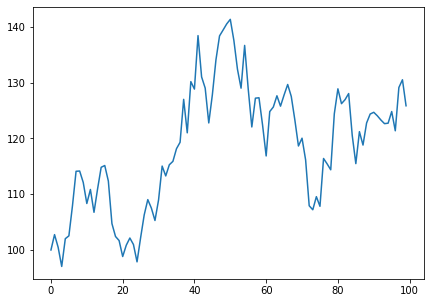

In [27]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
path = path_generator.generate_path(1,100).flatten()
print(f"Final price value is : {path[-1]:.2f}")
plot_path(path)

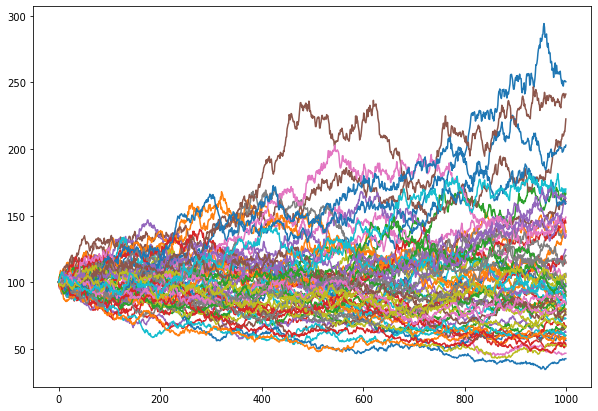

In [28]:
plot_path(path_generator.generate_path(n_paths = 60,n_steps = 1000),scale=1.5)

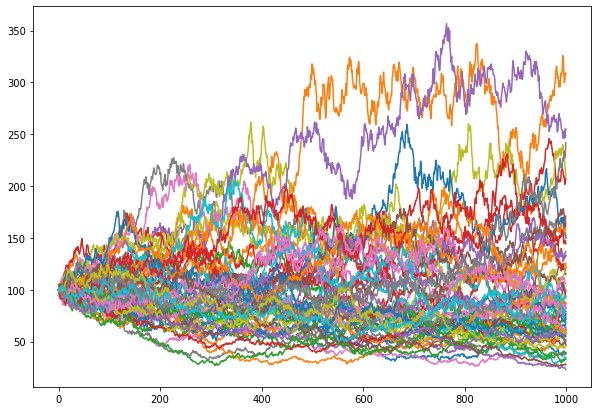

In [29]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
kappa = 1.5
theta = 0.5
vol_of_vol = 0.3
rho = 0.1

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})
plot_path(path_generator.generate_path(n_paths = 60,n_steps = 1000),scale=1.5)

## PayOff class

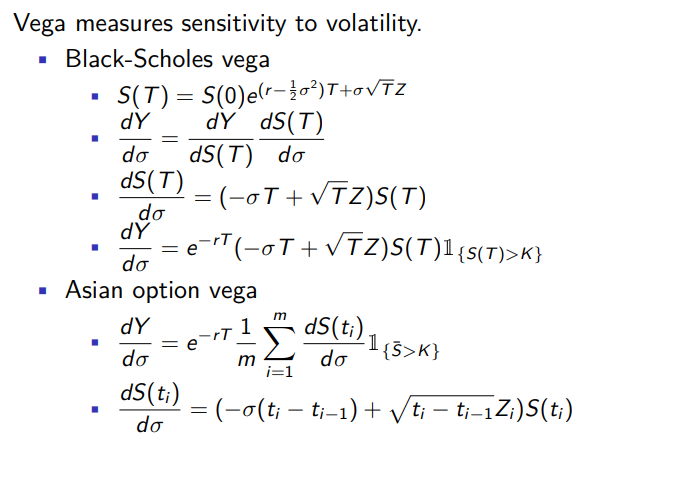

In [30]:
class PayOff:
  """
  Used to compute the payoff of a derivative using "payoff_func" and its arguments "payoff_func_all_args"
  payoff_func is of type : function(price_vector,**args)->payoff
  It is refactored into type : function(price_vector)->payoff using lambda function
  Same for the derivative of the function payoff, used for the pathwise greek evaluation method
  """
  def __init__(self,payoff_func_all_args,**kwargs):
        self.__payoff_func = lambda x : payoff_func_all_args(x,**kwargs)

  def compute_payoff(self,price_paths : np.ndarray) -> np.ndarray:
        if len(price_paths.shape)==1:
          return self.__payoff_func(price_paths)
        else:
          return np.apply_along_axis(self.__payoff_func,axis = 0,arr = price_paths)

In [31]:
def asian_call(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of an asian call option with strike K and geometric mean
    """
    geometric_mean = np.power(np.prod(price_vector),1/price_vector.shape[0])
    return max(0.,geometric_mean-K)

In [32]:
def european_call(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of a european call option with strike K
    """
    return max(0.,price_vector[-1]-K)

In [33]:
payoff = PayOff(european_call,K = 95)
print(payoff.compute_payoff(np.array([[100,90],[100,95],[100,100],[100,105]]).T))

[ 0.  0.  5. 10.]


## Monte Carlo Pricer class


In [45]:
class MonteCarloPricer:
  """
  Used to price a derivative using Monte-Carlo methods
  inputs : 
      PathGenerator object -> to gen the possible prices-curve that the asset can take
      PayOff object -> to compute the payoff of the prices for each case
  """
  def __init__(self,payoff : PayOff = None,payoff_func : callable = None,payoff_func_kwargs : dict = {},
               path_generator : PathGenerator = None, r :float= None,sigma :float = None,S0 :float = None,
               T : float = None,price_move_function : callable = None,price_move_function_args : dict = {}):

      if payoff is None and payoff_func is None:
          raise Exception("Incorrect 'Payoff' parameters passed")
      if path_generator is None and (sigma is None and S0 is None and T is None and r is None and price_move_function):
        raise Exception("Incorrect 'Path Generators' parameters passed")

      self.payoff = payoff if payoff else PayOff(payoff_func,**payoff_func_kwargs)

      self.path_generator = path_generator if path_generator else PathGenerator(S0 = S0,T = T,r=r,sigma = sigma,price_move_function = price_move_function,
                                                                                price_move_function_args=price_move_function_args)
      self.__r = self.path_generator.get_r()
      self.__T = self.path_generator.get_T()
      self.__sigma = self.path_generator.get_sigma()
      self.__S0 = self.path_generator.get_S0()

  @time_it
  def generate_path_and_payoff(self,n_paths:int,n_steps:int,epsilon_S:float=0.,z:np.ndarray=None,plot_path_bool=False,seed=None):
      """
      Generate a prices matrix of shape (n_paths x n_steps) using the path_generator object
      Computes the payoff of each price trajectory using the payoff object
      returns the mean of the payoff
      """
      
      prices = self.path_generator.generate_path(n_paths=n_paths,n_steps=n_steps,S_impact=epsilon_S,seed=seed)
      payoffs = self.payoff.compute_payoff(prices)
      payoffs *= np.exp(-self.__r * self.__T)
      if plot_path_bool:  plot_path(prices)
      return prices,payoffs

  def price_derivative(self,n_paths:int,n_steps:int)->float:
      _,payoffs = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps)
      return payoffs.mean()

  def quotient_greek(self,n_paths:int,n_steps:int,eps_scale:float = 1/8)->dict:
    """
    Compute the greeks of the derivative using the quotient_method
    """
    epsilon_S = self.__S0*eps_scale
    epsilon_sigma = self.__sigma*eps_scale

    seed = int(round(random(),5)*10000)

    _,payoffs_minus_e_s = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,epsilon_S = -epsilon_S,seed=seed)
    _,payoffs = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)
    _,payoffs_plus_e_s = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,epsilon_S = epsilon_S,seed=seed)

    delta = (payoffs_plus_e_s.mean() - payoffs_minus_e_s.mean()) / (2*epsilon_S)
    gamma = (payoffs_plus_e_s.mean() - 2*payoffs.mean() + payoffs_minus_e_s.mean()) / (epsilon_S*epsilon_S)

    self.path_generator.set_sigma(self.__sigma - epsilon_sigma)
    _,payoffs_minus_e_sigma = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)

    self.path_generator.set_sigma(self.__sigma + epsilon_sigma)
    _,payoffs_plus_e_sigma = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)

    self.path_generator.set_sigma(self.__sigma)

    vega = (payoffs_plus_e_sigma.mean() - payoffs_minus_e_sigma.mean()) / (2*epsilon_sigma)

    return {"delta":delta,"vega":vega,"gamma":gamma}

## Black-Scholes-Merton Call greeks ($\Delta,\gamma,vega$)

In [35]:
def pathwise_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int,n_steps:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
    payoff = PayOff(european_call,K=95)

    mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

    prices,payoffs = mcpricer.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps)
    ST = prices[-1,:]

    indic_greater_than_K = lambda array : np.where(array[-1]>K,1.,0.)

    delta_array = np.exp(-r * T) * indic_greater_than_K(prices) * ST / S0
    delta = delta_array.mean()

    vega_array = np.exp(-r * T) * ( np.log(ST/S0) - (r + sigma * sigma/2) * T) / sigma * indic_greater_than_K(prices) * ST 
    vega = vega_array.mean()
    
    gamma = np.nan

    return {"delta":delta,"vega":vega,"gamma":gamma}

def likelihood_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    Z = np.random.normal(size=(n_paths))

    ST = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    discounted_payoff = np.exp(-r*T) *np.where(ST-K>=0,ST-K,0)

    delta_array =  discounted_payoff * Z / (S0*sigma*np.sqrt(T))
    delta = delta_array.mean()

    gamma_array = discounted_payoff * ((Z*Z-1)/(S0*S0*sigma*sigma*T) - Z/(S0*S0*sigma*np.sqrt(T)))
    gamma = gamma_array.mean()

    vega_array = discounted_payoff * ((Z*Z-1)/sigma - np.sqrt(T)*Z)
    vega = vega_array.mean()
    
    return {"delta":delta,"vega":vega,"gamma":gamma}

def quotient_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    Z = np.random.normal(size=(n_paths))

    epsilon_S = S0/100
    epsilon_sigma = sigma/100

    ST = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    ST_plus_eS = (S0+epsilon_S) * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    ST_minus_eS = (S0-epsilon_S) * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma-epsilon_sigma
    ST_minus_esigma = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma+2*epsilon_sigma
    ST_plus_esigma = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma-epsilon_sigma

    discounted_payoff = lambda prices : np.exp(-r*T) *np.where(prices-K>=0,prices-K,0).mean()

    delta = (discounted_payoff(ST_plus_eS) - discounted_payoff(ST))/epsilon_S
    gamma = (discounted_payoff(ST_plus_eS) - 2*discounted_payoff(ST) + discounted_payoff(ST_minus_eS))/(2*epsilon_S)
    vega = (discounted_payoff(ST_plus_esigma) - discounted_payoff(ST))/epsilon_sigma
    
    return {"delta":delta,"vega":vega,"gamma":gamma}

## Analytical (closed-form) solution

In [36]:
def closed_form_call_price(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_value = S0 * norm_cdf(d1) - K * np.exp(-r * T) * norm_cdf(d2)
    return call_value

def closed_form_call_delta(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm_cdf(d1)

def closed_form_call_gamma(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

def closed_form_call_vega(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) * np.sqrt(T) * S0

def norm_cdf(x:float)->float:
    return (1.0 + erf(x / np.sqrt(2.0))) / 2.0

## Base model and Task n°1

In [96]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(european_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = mcpricer.price_derivative(n_paths=100000,n_steps=100)


quotient_greek = quotient_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = 10000)
quotient_greek_class_func = mcpricer.quotient_greek(n_paths=10000,n_steps=1000)
pw_greek = pathwise_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = 10000,n_steps=1000)
likelihood_greek = likelihood_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = 10000)

print(f"Derivative fair value is {fair_value:.3f}")

print(f"\n{'Quotient method':_^40}")
print(f"Derivative delta is {quotient_greek.get('delta'):.3f}")
print(f"Derivative gamma is {quotient_greek.get('gamma'):.3f}")
print(f"Derivative vega is {quotient_greek.get('vega'):.3f}")

print(f"\n{'Quotient method (class func)':_^40}")
print(f"Derivative delta is {quotient_greek_class_func.get('delta'):.3f}")
print(f"Derivative gamma is {quotient_greek_class_func.get('gamma'):.3f}")
print(f"Derivative vega is {quotient_greek_class_func.get('vega'):.3f}")

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is {pw_greek.get('delta'):.3f}")
print(f"Derivative gamma is {pw_greek.get('gamma'):.3f}")
print(f"Derivative vega is {pw_greek.get('vega'):.3f}")

print(f"\n{'Likelihood method':_^40}")
print(f"Derivative delta is {likelihood_greek.get('delta'):.3f}")
print(f"Derivative gamma is {likelihood_greek.get('gamma'):.3f}")
print(f"Derivative vega is {likelihood_greek.get('vega'):.3f}")

Execution time is  0.99 seconds
Execution time is  0.61 seconds
Execution time is  0.62 seconds
Execution time is  0.60 seconds
Execution time is  0.64 seconds
Execution time is  0.63 seconds
Execution time is  0.59 seconds
Derivative fair value is 17.861

____________Quotient method_____________
Derivative delta is 0.625
Derivative gamma is 0.005
Derivative vega is 36.389

______Quotient method (class func)______
Derivative delta is 0.622
Derivative gamma is 0.009
Derivative vega is 38.278

____________Pathwise method_____________
Derivative delta is 0.637
Derivative gamma is nan
Derivative vega is 38.280

___________Likelihood method____________
Derivative delta is 0.579
Derivative gamma is 0.007
Derivative vega is 29.140


In [38]:
fair_value = closed_form_call_price(r=r,sigma = sigma,T=T,S0=S0,K=K)
delta = closed_form_call_delta(r=r,sigma = sigma,T=T,S0=S0,K=K)
gamma = closed_form_call_gamma(r=r,sigma = sigma,T=T,S0=S0,K=K)
vega = closed_form_call_vega(r=r,sigma = sigma,T=T,S0=S0,K=K)

print(f"Derivative fair value (closed-form) is {fair_value:.3f}")
print(f"Derivative delta (closed-form) is {delta:.3f}")
print(f"Derivative gamma (closed-form) is {gamma:.3f}")
print(f"Derivative vega (closed-form) is {vega:.3f}")

Derivative fair value (closed-form) is 18.023
Derivative delta (closed-form) is 0.627
Derivative gamma (closed-form) is 0.009
Derivative vega (closed-form) is 37.842


## Asian/Stochastic Volatility Options

### Pricing the asian call using BSM model

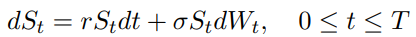

In [101]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(asian_call,K=K)

aisan_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = aisan_BSM_pricer.price_derivative(n_paths=10000,n_steps=100)
print(f"Option fair-value is {fair_value:.3f}")

Execution time is  0.31 seconds
Option fair-value is 9.361


### Pricing the asian call using Heston model

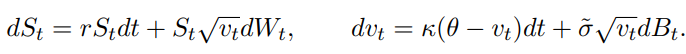

In [103]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4 # sigma = sqrt(v0)
K = 100
kappa = 1.5
theta = 0.5
vol_of_vol = 0.3
rho = 0.1

# kappa = 0.
# vol_of_vol = 0.

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})
payoff = PayOff(asian_call,K=K)

asian_heston_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = asian_heston_pricer.price_derivative(n_paths=10000,n_steps=100)

asian_heston_quotien_greek_ = asian_heston_pricer.quotient_greek(n_paths=100000,n_steps=100)

print(f"Option fair-value is {fair_value:.3f}")
print(f"\n{'Greeks (quotient method)':_^40}")
print(f"Derivative delta is {asian_heston_quotien_greek_.get('delta'):.3f}")
print(f"Derivative gamma is {asian_heston_quotien_greek_.get('gamma'):.3f}")
print(f"Derivative vega is {asian_heston_quotien_greek_.get('vega'):.3f}")

Execution time is  0.31 seconds
Execution time is  3.73 seconds
Execution time is  3.31 seconds
Execution time is  4.09 seconds
Execution time is  3.17 seconds
Execution time is  3.04 seconds
Option fair-value is 11.132

________Greeks (quotient method)________
Derivative delta is 0.531
Derivative gamma is 0.013
Derivative vega is 10.144


## Barrier/Look-back Options

In [42]:
def barrier_call(price_vector : np.ndarray,K : float,B : float) -> float:
    """
    Returns the payoff of an barrier call option with strike K and barrier level B
    """
    payoff = max(0.,price_vector[-1]-K)
    payoff_condition = price_vector.max() <= B
    return payoff if payoff_condition else 0

In [43]:
S0 = 100
r = 0.1
T = 0.25
sigma = 0.1
K = 95.
B = 120.

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(barrier_call,K=K,B=B)

barrier_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = barrier_BSM_pricer.price_derivative(n_paths=10000,n_steps=100)
print(f"Option fair-value is {fair_value:.3f}")

Execution time is  0.14 seconds
Option fair-value is 7.459
